In [1]:
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error

In [2]:
studInfo = pd.read_csv("studentInfo.csv")
assessments = pd.read_csv("assessments.csv")
studAss = pd.read_csv("studentAssessment.csv")
studVle = pd.read_csv("studentVle.csv")

In [3]:
others = assessments[assessments["assessment_type"] != "Exam"]
stud_ass = pd.merge(studAss, others, on="id_assessment")
stud_ass["weighted_grade"] = (stud_ass["score"] * stud_ass["weight"]) / 100
avg_grade = stud_ass.groupby(["id_student", "code_module", "code_presentation"])["weighted_grade"].sum().reset_index()

In [4]:
stud_ass["is_pass"] = stud_ass["score"] >= 40
pass_count = stud_ass[stud_ass["is_pass"]].groupby(["id_student", "code_module", "code_presentation"]).size().reset_index(name='pass_count')
amounts = others.groupby(["code_module", "code_presentation"]).size().reset_index(name='total_assessments')
pass_rate_df = pd.merge(pass_count, amounts, on=["code_module", "code_presentation"])
pass_rate_df["pass_rate"] = pass_rate_df["pass_count"] / pass_rate_df["total_assessments"]

In [5]:
avg_per_student = studVle.groupby(["id_student", "code_module", "code_presentation"])["sum_click"].sum().reset_index()
studInfo['target'] = studInfo['final_result'].map({'Pass': 1, 'Distinction': 1, 'Fail': 0, 'Withdrawn': 0})

In [6]:
df_merged = pd.merge(avg_grade, pass_rate_df[['id_student', 'pass_rate', 'code_module', 'code_presentation']], on=["id_student", "code_module", "code_presentation"])
df_merged = pd.merge(studInfo[['id_student', 'code_module', 'code_presentation', 'target', 'num_of_prev_attempts']], df_merged, on=["id_student", "code_module", "code_presentation"])
final_df = pd.merge(df_merged, avg_per_student, on=["id_student", "code_module", "code_presentation"])

In [7]:
features = ['num_of_prev_attempts', 'weighted_grade', 'pass_rate', 'sum_click']
X = final_df[features]
y = final_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
model_xgb = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, eval_metric='logloss')
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [9]:
preds = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)

In [10]:
print(f"Classification Accuracy: {accuracy:.2%}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print("\nClassification Report:\n", classification_report(y_test, preds))

Classification Accuracy: 90.04%
Mean Absolute Error (MAE): 0.0996

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.82      0.86      1916
           1       0.89      0.95      0.92      3123

    accuracy                           0.90      5039
   macro avg       0.90      0.88      0.89      5039
weighted avg       0.90      0.90      0.90      5039



In [19]:
from xgboost import XGBClassifier

# Define the model (ensure the variable name is 'model')
model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, eval_metric='logloss')

# Train the model
model.fit(X_train, y_train)

# Now 'model' is defined and you can run visualizations

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

<Figure size 1000x600 with 0 Axes>

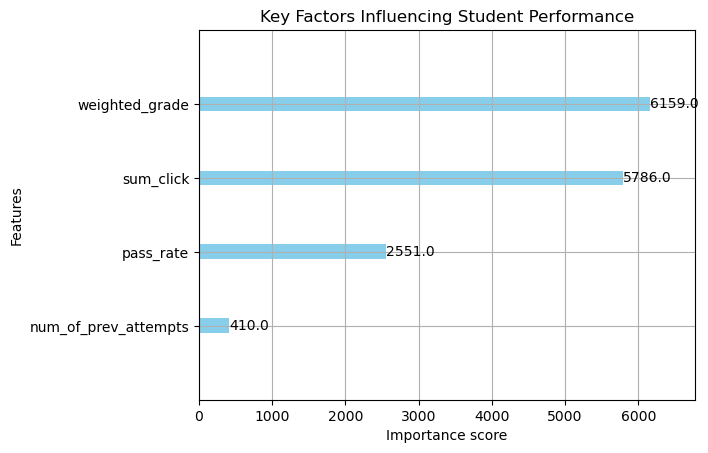

In [23]:
plt.figure(figsize=(10, 6))
plot_importance(model, color='skyblue')
plt.title("Key Factors Influencing Student Performance")
plt.show()

<Figure size 800x600 with 0 Axes>

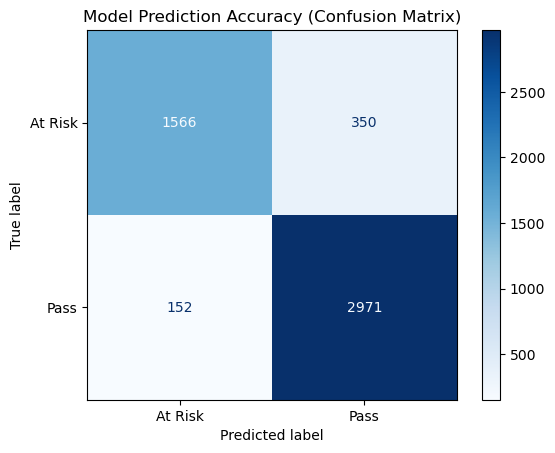

In [24]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['At Risk', 'Pass'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Model Prediction Accuracy (Confusion Matrix)")
plt.show()

In [25]:
y_probs = model.predict_proba(X_test)[:, 1] # Get probability for the "Pass" class
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

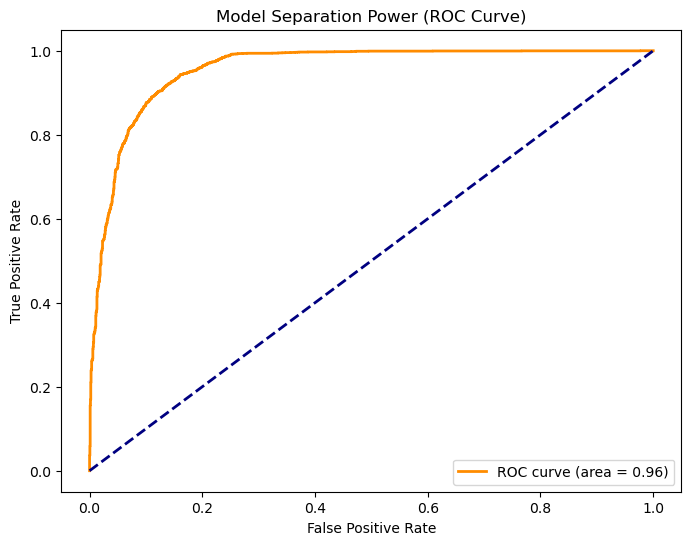

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Separation Power (ROC Curve)')
plt.legend(loc="lower right")
plt.show()

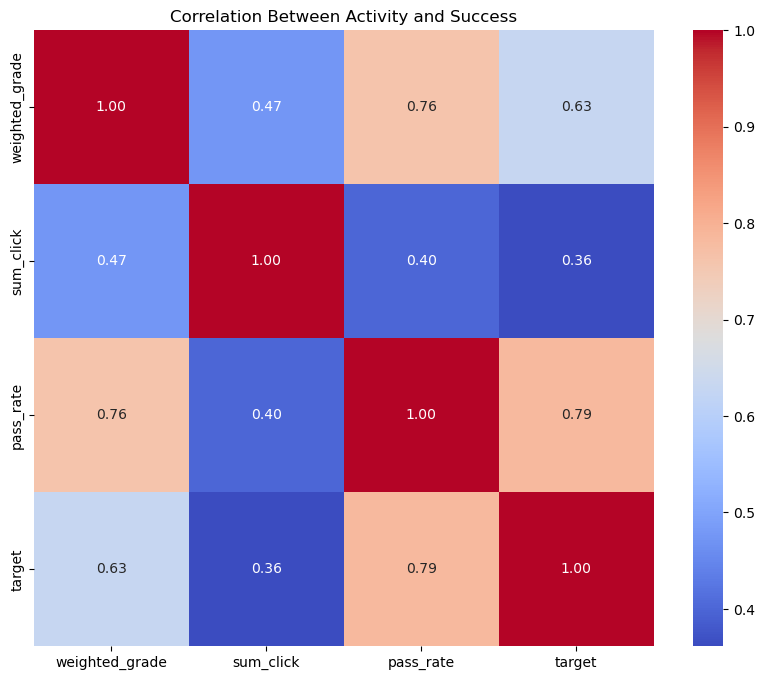

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(final_df[['weighted_grade', 'sum_click', 'pass_rate', 'target']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Activity and Success")
plt.show()

In [20]:
joblib.dump(model, 'student_model.pkl')

['student_model.pkl']